In [1]:
% ignore - internal setup
path('../scripts/quadpenalty', path)
set(0, 'DefaultLineLineWidth', 2)
set(0, 'DefaultAxesFontSize', 14);

# Penalty Methods

Penalty methods have been superseded by more effective methods and are not used anymore, but they are easy to understand and provide a good jumping off point.  Consider the simple example we've seen in class:

$$
\begin{align*}
\text{minimize} &\quad  x_1 + x_2\\
\text{subject to} &\quad  x_1^2 + x_2^2 = 8\\
\end{align*}
$$

In [ ]:
function [f, c] = func(x)

    f = x(1) + x(2);
    c = x(1)^2 + x(2)^2 - 8;

end

Let's use a simple quadratic penalty of the form
$$J(x; \mu) = f(x) + \frac{\mu}{2}\sum_i \hat{c}_i(x)^2$$

In [ ]:
function J = quadpenalty(x, mu)

    [f, c] = func(x);
    P = mu/2.0*c^2;
    J = f + P;

end


Let's plot contours of the original function.

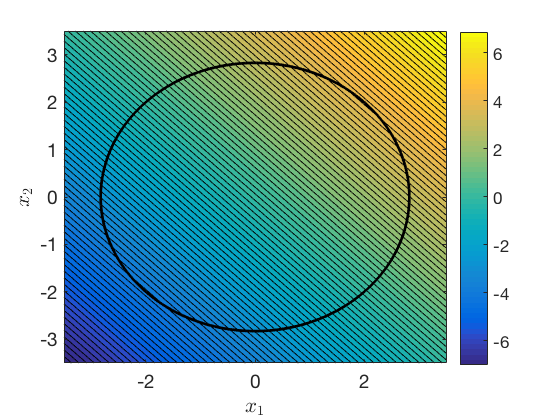

In [13]:
n = 100;
x1 = linspace(-3.5, 3.5, n);
x2 = linspace(-3.5, 3.5, n);
[X1, X2] = ndgrid(x1, x2);

J = zeros(n, n);
C = zeros(n, n);
for i = 1:n
    for j = 1:n
        [J(i, j), C(i, j)] = func([X1(i, j), X2(i, j)]);
    end
end

figure();
contourf(X1, X2, J, 100);
hold on;
colorbar();
contour(X1, X2, C, [0, 0], 'k', 'LineWidth', 2);
xlabel('$x_1$','Interpreter','latex');
ylabel('$x_2$','Interpreter','latex');

Now let's plot what our unconstrained quadratic penalty function looks like for some value of $\mu$.

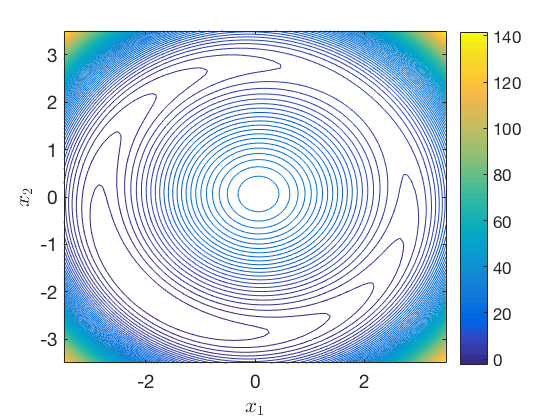

In [16]:
mu = 1.0;

for i = 1:n
    for j = 1:n
        J(i, j) = quadpenalty([X1(i, j), X2(i, j)], mu);
    end
end
        
figure();
contour(X1, X2, J, 100);
colorbar();
xlabel('$x_1$','Interpreter','latex');
ylabel('$x_2$','Interpreter','latex');

The minimum, is near, but not exactly at the solution $x^* = (-2, -2)$.  As we increase the value of $\mu$, the solution to the unconstrained problem gets nearer the actual solution, but the optimization problem becomes increasingly harder to solve because of the poor scaling.

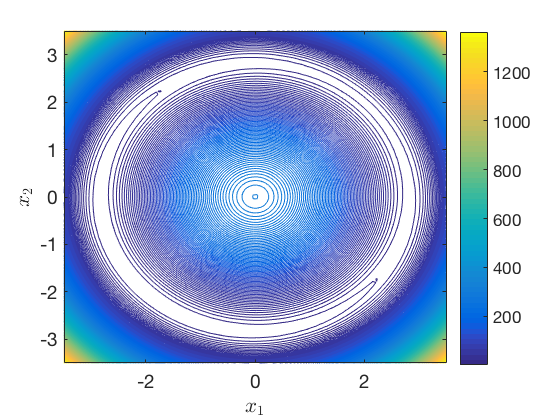

In [25]:
mu = 10.0;

for i = 1:n
    for j = 1:n
        J(i, j) = quadpenalty([X1(i, j), X2(i, j)], mu);
    end
end
        
figure();
contour(X1, X2, J, 300);
colorbar();
xlabel('$x_1$','Interpreter','latex');
ylabel('$x_2$','Interpreter','latex');

Conversely, if the penalty is not steep enough to begin with, then the problem may be unbounded from below.

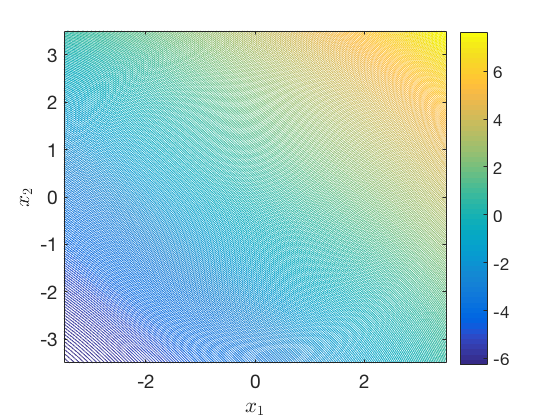

In [26]:
mu = 0.005;

for i = 1:n
    for j = 1:n
        J(i, j) = quadpenalty([X1(i, j), X2(i, j)], mu);
    end
end
        
figure();
contour(X1, X2, J, 300);
colorbar();
xlabel('$x_1$','Interpreter','latex');
ylabel('$x_2$','Interpreter','latex');

Let's iteratively optimize this unconstrained problem with different values of $\mu$ and see the change in the objective value and x value.  Note that both x values are the same because of the symmetry of the problem, so we just plot one.

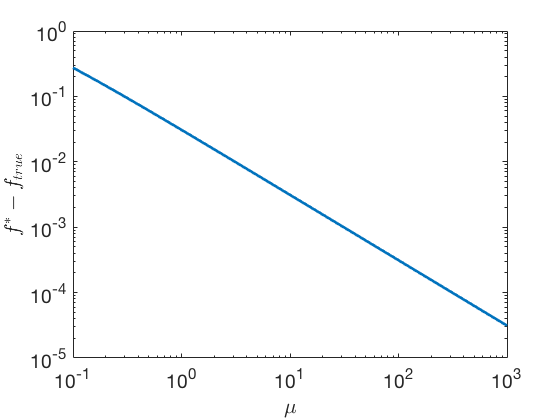

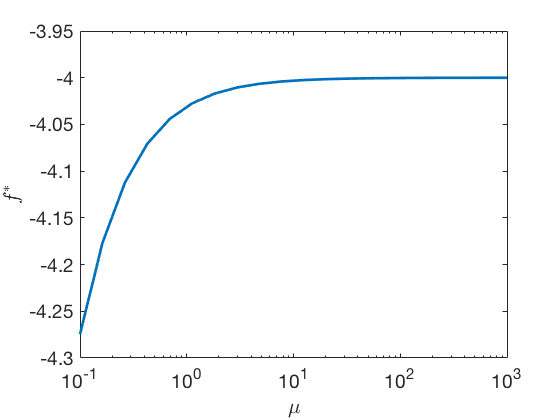

In [44]:
% iterate
n = 20;
muvec = logspace(-1, 3, n);
fstar = zeros(n, 1);

% starting point
x0 = [0.0, 0.0];

options = optimoptions('fminunc','display', 'off', 'algorithm', 'quasi-newton');

for i = 1:n
    obj = @(x) quadpenalty(x, muvec(i));
    
    [xs, fstar(i)] = fminunc(obj, x0, options);
end

figure;
semilogx(muvec, fstar);
xlabel('$\mu$','Interpreter','latex');
ylabel('$f^*$','Interpreter','latex');
ylim([-4.3, -3.95]);

figure;
loglog(muvec, abs(fstar) - 4.0);
xlabel('$\mu$','Interpreter','latex');
ylabel('$f^* - f_{true}$','Interpreter','latex');

Notice that to achieve reasonable accuracies, we need to make $\mu$ fairly large.  For more complicated problems in higher dimensions, the scaling is very poor and it is difficult to solve with large $\mu$.  Generally, you have to settle for a highly approximate solution using this approach.

# Augmented Lagrangian

We can improve upon these simple penalty methods by using an Augmented Lagrangian approach.  Again, there are better constrained optimization methods (SQP, interior-point) that are used now, but I provide this description for those interested as Augmented Lagrangians are still useful as a merit function in some applications.

The quadratic penalty method always produce infeasible results.  We can show that each constraint is approximately:
$$c(x) \approx \frac{\lambda^*}{\mu}$$
Thus, we cannot satisfy active constraints without making $\mu \rightarrow \infty$.

We can use that information to do better.  Specifically, we can try to estimate the Lagrange multiplier to form a better objective.  We add the quadratic penalty to an estimate of the Lagrangian and call it the \alert{augmented Lagrangian}:
$$\mathcal{L}(x, \lambda; \mu) = f(x) + \sum_i \lambda_i c_i(x) + \frac{\mu}{2}\sum_i c_i(x)^2$$

Looking at the optimality conditions of this problem:
$$\nabla_x \mathcal{L}(x, \lambda; \mu) = \nabla f + \sum_i [\lambda_i + \mu c_i] \nabla c_i = 0$$
Compared to the actual optimality conditions of the constrained problem:
$$\nabla f + \lambda^* \nabla c = 0$$
Suggests an estimate for $\lambda^*$:
$$\lambda^* \approx \lambda_i + \mu c_i(x)$$

Rearranging by solving for c(x):
$$c(x) \approx \frac{1}{\mu}(\lambda^* - \lambda_i)$$
Compared to previous result using just the quadratic penalty:
$$c(x) \approx \frac{\lambda^*}{\mu}$$
This suggests that we can reduce error by doing one of two things: by increasing $\mu$ or by providing an estimate of $\lambda_i$ that is closer to its true value.

$$\lambda^* \approx \lambda_i + \mu c_i(x)$$

This suggests an update rule for our estimate of $\lambda$:
$$\lambda_i^{k+1} = \lambda_i^{k} + \mu_k c_i(x_k)$$

Using an Augmented Lagrangian allows us to assure convergence without increasing $\mu \rightarrow \infty$, which addresses issues of ill-conditioning (update $\mu$ less frequently).  It also gives us two ways to improve accuracy instead of one.

Let's compare the same penalty parameter for a quadratic penalty and an augmented Lagrangian.  Notice that the quadratic penalty is unbounded from below, whereas with a reasonable estimate of $\lambda$ we can still have a very low value for the penalty parameter.

In [ ]:
function J = augmented(x, mu, lam)

    [f, c] = func(x);
    P = mu/2.0*c^2;
    J = f + lam*c + P;

end

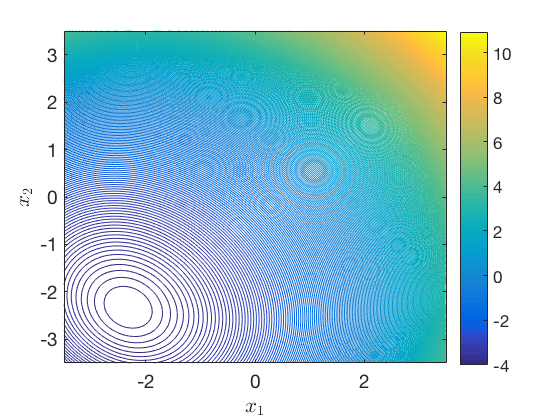

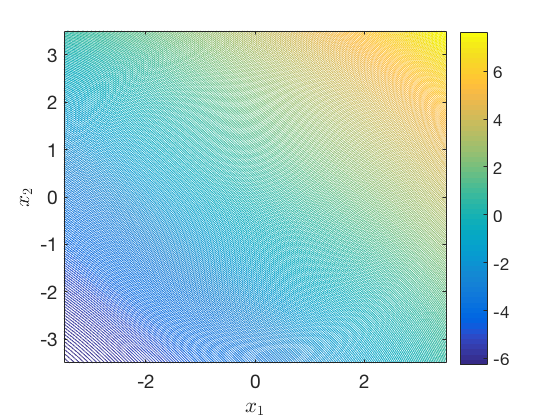

In [46]:
mu = 0.005;
lam = 0.2;

n = 100;

for i = 1:n
    for j = 1:n
        J(i, j) = quadpenalty([X1(i, j), X2(i, j)], mu);
    end
end
        
figure();
contour(X1, X2, J, 300);
colorbar();
xlabel('$x_1$','Interpreter','latex');
ylabel('$x_2$','Interpreter','latex');


for i = 1:n
    for j = 1:n
        J(i, j) = augmented([X1(i, j), X2(i, j)], mu, lam);
    end
end

figure();
contour(X1, X2, J, 300);
colorbar();
xlabel('$x_1$','Interpreter','latex');
ylabel('$x_2$','Interpreter','latex');